In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy.io
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torch
# import seaborn as sns

from gglm.glm.base import GLM
from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
# from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from sptr.sptr import SpikeTrain
# from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

palette = dict(d='C0', ml='C2', mmd='C1')

In [2]:
npz = np.load('/home/diego/python/generative-glm/cool_stuff/reliability4.npz')
t, mask_spikes_d, mask_spikes_fr_ml, stim  = npz['t'], npz['mask_spikes_d'], npz['mask_spikes_fr'], npz['stim']

u0_ml, tbins_kappa, coefs_kappa, tbins_eta, coefs_eta = float(npz['glm_u0']), npz['glm_tbins_kappa'], npz['glm_coefs_kappa'], npz['glm_tbins_eta'], npz['glm_coefs_eta']
nll = npz['log_likelihood']
dt = t[1]
argt = 500

n_batch_d = mask_spikes_d.shape[1]
n_train = 100
# n_batch_fr = mask_spikes_fr.shape[1]

mask_spikes_train = mask_spikes_d[:, :n_train]
mask_spikes_train_torch = torch.from_numpy(mask_spikes_train.copy())
mask_spikes_val = mask_spikes_d[:, n_train:]
stim_train = stim[:, :n_train]
# stim_train_torch
stim_val = stim[:, n_train:]
st_d_train = SpikeTrain(t, mask_spikes_train)
st_d_val = SpikeTrain(t, mask_spikes_val)
st_fr_ml = SpikeTrain(t, mask_spikes_fr_ml)

 epoch 599 of 600 loss -2.4861261094mmd 0.12838994489043162 0.22000243024912033 0.348392375139552
ml 0.2566591677792513 0.16867129949620624 0.42533046727545754


Text(0.5, 0, 'time (ms)')

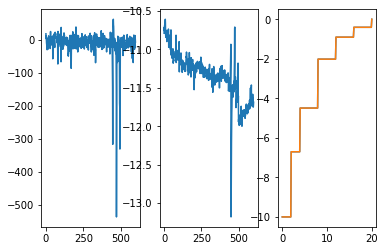

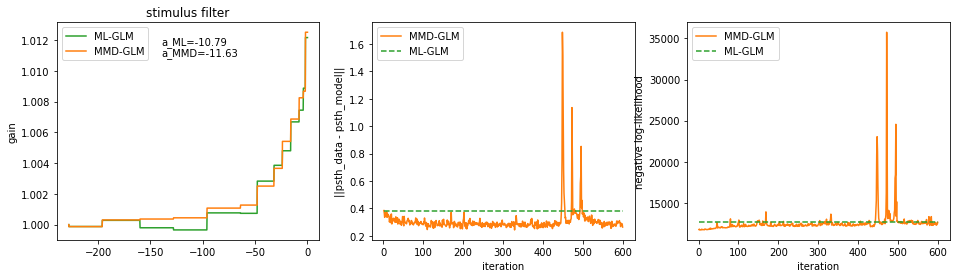

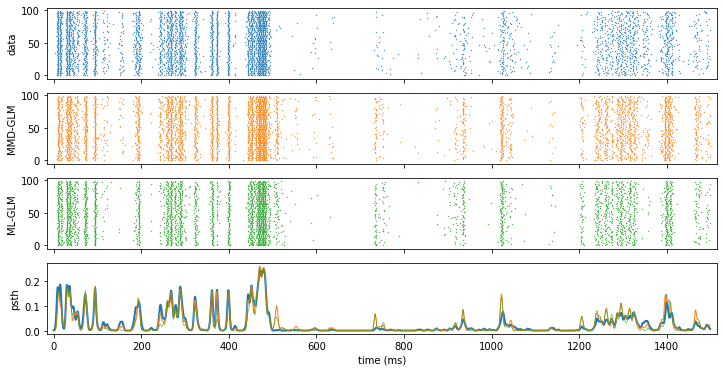

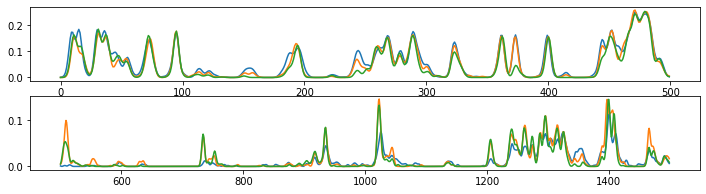

In [3]:
kappa_ml = KernelRect(tbins=tbins_kappa, coefs=coefs_kappa)
eta_ml = KernelRect(tbins=tbins_eta, coefs=coefs_eta)

u0_mmd = u0_ml
kappa_mmd = kappa_ml.copy()
eta_mmd = eta_ml.copy()

# u0_mmd = -12
# kappa_mmd.coefs = kappa_mmd.coefs * 0 + 2e-3 * 0

mmdglm = MMDGLM(u0=u0_mmd, kappa=kappa_mmd.copy(), eta=eta_mmd.copy())
# mmdglm.non_linearity_torch = lambda x: torch.exp(x)
# mmdglm.non_linearity = lambda x: np.exp(x)

kernel_conv = KernelFun.gaussian_delta(2)
# delta = 1
# kernel_conv = KernelRect(tbins=[-delta, delta], coefs=[1 / (2 * delta)])

def kernel_psth(t,  mask_spikes1, mask_spikes2):
    st1 = SpikeTrain(t, mask_spikes1)
    st2 = SpikeTrain(t, mask_spikes2)
    psth1 = st1.convolve(kernel_conv)
    psth2 = st2.convolve(kernel_conv)
    gramian = np.sum(psth1[:, :, None] * psth2[:, None, :], 0)
    gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kernel_psth

def metrics(mmdglm, t, mask_spikes, X_dc, n_batch_fr):
#     mmdglm.sample_conditioned(t, mask_spi)
    theta_g = torch.cat((mmdglm.b, mmdglm.kappa_coefs, mmdglm.eta_coefs)).detach()
    u_dc = torch.einsum('tka,a->tk', X_dc, theta_g)
    r_dc = torch.exp(u_dc)
#     neg_log_likelihood_mmd = -torch.sum(u_dc * mask_spikes.double() - 1 * r_dc)
#     neg_log_likelihood_mmd = -torch.sum(torch.log(1 - torch.exp(-dt * r_dc) + 1e-20) * mask_spikes.double() - \
#                                       dt * r_dc * (1 - mask_spikes.double()))
    neg_log_likelihood_mmd = -(torch.sum(torch.log(1 - torch.exp(-dt * r_dc[mask_spikes])) + 1e-20) - \
                                      dt * torch.sum(r_dc[~mask_spikes]))
    return dict(nll=neg_log_likelihood_mmd, b=mmdglm.u0)

mmd_ml = torch.mean(kernel_psth(t,  mask_spikes_train, mask_spikes_train)[np.triu_indices(mask_spikes_train.shape[1], k=1)]) \
        + torch.mean(kernel_psth(t,  mask_spikes_fr_ml, mask_spikes_fr_ml)[np.triu_indices(mask_spikes_train.shape[1], k=1)]) \
        -2 * torch.mean(kernel_psth(t,  mask_spikes_train, mask_spikes_fr_ml))

# 1 result
# num_epochs, lr = 1000, 2e-4
# kernel_conv = KernelFun.gaussian_delta(20)

n_batch = 1
# stim_train = np.stack([stim_train[:, 0]] * n_batch_fr, 1)
lam_mmd = 1e0
ll, num_epochs, lr = False, 600, 5e-5

psth_val = np.mean(st_d_val.convolve(kernel_conv), 1)
psth_ml = np.mean(st_fr_ml.convolve(kernel_conv), 1)
# lr = 1e-4
# optim = Adam(mmdglm.parameters(), lr=lr, betas=(0.9, 0.999))

# optim = Adam([{'params': mmdglm.b, 'lr': 4e-4}, 
#               {'params': mmdglm.kappa_coefs, 'lr': 1e-5}, 
#               ], lr=1e-3, betas=(0, 0))

optim = SGD([{'params': mmdglm.b, 'lr': 4e-1}, 
              {'params': mmdglm.kappa_coefs, 'lr': 2e-7}, 
              ], lr=1e-10)

loss, mmd, metrics_list = mmdglm.train(t, mask_spikes_train_torch, phi=phi, kernel=kernel, stim=stim_train, 
                                       log_likelihood=ll, lam_mmd=lam_mmd, optim=optim, num_epochs=num_epochs, n_batch_fr=0, 
                                       n_batch=n_batch,
                                       verbose=True, metrics=metrics)
loss, mmd = np.array(loss), np.array(mmd)
nll = torch.tensor(metrics_list['nll'])
b_mmd = torch.tensor(metrics_list['b'])

u_fr_mmd, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, stim=stim_val)
st_fr_mmd = SpikeTrain(t, mask_spikes_fr_mmd)
psth_mmd = np.mean(st_fr_mmd.convolve(kernel_conv), 1)

iterations = np.arange(1, num_epochs + 1, 1)

print('mmd', np.sum((psth_val[:argt] - psth_mmd[:argt])**2), np.sum((psth_val[argt:] - psth_mmd[argt:])**2), 
      np.sum((psth_val - psth_mmd)**2))
print('ml', np.sum((psth_val[:argt] - psth_ml[:argt])**2), np.sum((psth_val[argt:] - psth_ml[argt:])**2), 
      np.sum((psth_val - psth_ml)**2))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.plot(loss)
ax2.plot(b_mmd)
eta_ml.plot(ax=ax3)
mmdglm.eta.plot(ax=ax3)

fig1, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 4), ncols=3)
kappa_ml.plot(ax=ax1, invert_t=True, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.kappa.plot(ax=ax1, invert_t=True, exp_values=True, label='MMD-GLM', color=palette['mmd'])
ax1.text(0.4, 0.9, 'a_ML=' + str(np.round(u0_ml, 2)), transform=ax1.transAxes)
ax1.text(0.4, 0.85, 'a_MMD=' + str(np.round(mmdglm.u0, 2)), transform=ax1.transAxes)
ax1.set_ylabel('time (ms)')
ax1.set_ylabel('gain')
ax1.set_title('stimulus filter')
ax1.legend()

ax2.plot(iterations, mmd, label='MMD-GLM', color=palette['mmd'])
ax2.set_xlabel('iteration'); ax2.set_ylabel('||psth_data - psth_model||')
ax2.plot([1, num_epochs], [mmd_ml, mmd_ml], '--', label='ML-GLM', color=palette['ml'])
ax2.legend()
nll_ml = nll[-1]
ax3.plot(iterations, nll, label='MMD-GLM', color=palette['mmd'])
ax3.plot([1, num_epochs], [nll_ml, nll_ml], '--', label='ML-GLM', color=palette['ml'])
ax3.set_xlabel('iteration'); ax3.set_ylabel('negative log-likelihood')
ax3.legend()

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 6), nrows=4, ncols=1, sharex=True)
st_d_val.plot(ax=ax1, marker='.', ms=0.7, color=palette['d'])
ax1.set_ylabel('data')
st_fr_mmd.plot(ax=ax2, marker='.', ms=0.7, color=palette['mmd'])
ax2.set_ylabel('MMD-GLM')
st_fr_ml.plot(ax=ax3, marker='.', ms=0.7, color=palette['ml'])
ax3.set_ylabel('ML-GLM')
ax4.plot(t, psth_val, label='data', color=palette['d'], lw=2)
ax4.plot(t, psth_mmd, label='MMD-GLM', color=palette['mmd'], lw=1)
ax4.plot(t, psth_ml, label='ML-GLM', color=palette['ml'], lw=0.5)
ax4.set_ylabel('psth')
ax4.set_xlabel('time (ms)')

fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), nrows=2, ncols=1, sharex=False)
ax1.plot(t[:argt], psth_val[:argt], label='data', color=palette['d'])
ax1.plot(t[:argt], psth_mmd[:argt], label='MMD-GLM', color=palette['mmd'])
ax1.plot(t[:argt], psth_ml[:argt], label='ML-GLM', color=palette['ml'])
ax2.plot(t[argt:], psth_val[argt:], label='data', color=palette['d'])
ax2.plot(t[argt:], psth_mmd[argt:], label='MMD-GLM', color=palette['mmd'])
ax2.plot(t[argt:], psth_ml[argt:], label='ML-GLM', color=palette['ml'])
ax4.set_ylabel('psth')
ax4.set_xlabel('time (ms)')

Text(0.5, 17.200000000000003, 'time (ms)')

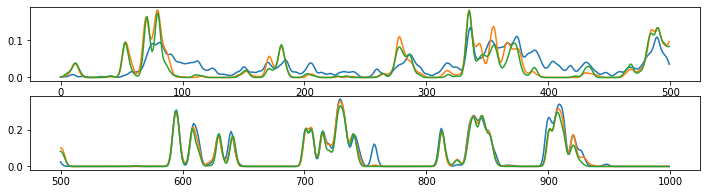

In [74]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), nrows=2, ncols=1, sharex=False)
ax1.plot(t[:argt], psth_val[:argt], label='data', color=palette['d'])
ax1.plot(t[:argt], psth_mmd[:argt], label='MMD-GLM', color=palette['mmd'])
ax1.plot(t[:argt], psth_ml[:argt], label='ML-GLM', color=palette['ml'])
ax2.plot(t[argt:], psth_val[argt:], label='data', color=palette['d'])
ax2.plot(t[argt:], psth_mmd[argt:], label='MMD-GLM', color=palette['mmd'])
ax2.plot(t[argt:], psth_ml[argt:], label='ML-GLM', color=palette['ml'])
ax4.set_ylabel('psth')
ax4.set_xlabel('time (ms)')

In [53]:
fig1.savefig('/home/diego/Dropbox/minimizing_psth1.png')
fig2.savefig('/home/diego/Dropbox/minimizing_psth2.png')

NameError: name 'nll' is not defined

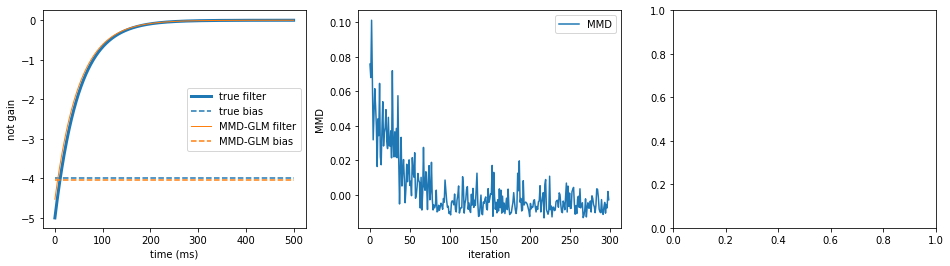

In [25]:
palette = dict(true='C0', mmd='C1')
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 4), ncols=3)
glm_true.eta.plot(ax=ax1, lw=3, color=palette['true'], label='true filter')
ax1.plot([glm_true.eta.support[0], glm_true.eta.support[1]], [glm_true.u0, glm_true.u0], '--', color=palette['true'], label='true bias')
mmdglm.eta.plot(ax=ax1, lw=1, color=palette['mmd'], label='MMD-GLM filter')
ax1.plot([mmdglm.eta.support[0], mmdglm.eta.support[1]], [mmdglm.u0, mmdglm.u0], '--', color=palette['mmd'], label='MMD-GLM bias')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('not gain')
ax1.legend()
ax2.plot(mmd, label='MMD')
ax2.set_xlabel('iteration')
ax2.set_ylabel('MMD')
ax2.legend()
ax3.plot(nll, label='NLL')
ax3.set_xlabel('iteration')
ax3.set_ylabel('NLL')
ax3.legend()

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/learning_history_filter.pdf')

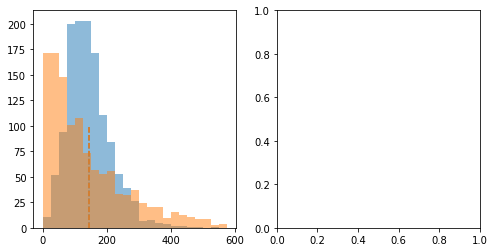

In [107]:
# num_epochs = 200
# lr = 5e-2

n = 100
eta_true = KernelFun.exponential([50], coefs=[-5])
glm_true = GLM(u0=-4, eta=eta_true.copy())

t = np.arange(0, 2000, 1)
_, _, mask_spikes_te = glm_true.sample(t, shape=(n,))
st_dc = SpikeTrain(t, mask_spikes_te)
isi_d = st_dc.isi_distribution(concatenate=False)
mean_d = np.mean(np.concatenate((isi_d)))

eta_fit = KernelFun.exponential([50], coefs=[0])
glm_fit = GLM(u0=-5, eta=eta_fit.copy())
u_fr_ml, r_fr_ml, mask_spikes_fr_ml = glm_fit.sample(t, shape=(n, ))
st_fr = SpikeTrain(t, mask_spikes_fr_ml)
isi_fr = st_fr.isi_distribution(concatenate=False)
mean_fr = np.mean(np.concatenate((isi_fr)))

phi1_d = np.array([np.sum(_isi) for _isi in isi_d])
phi2_d = np.array([np.sum(_isi**2) for _isi in isi_d])
counts_d = np.array([len(_isi**2) for _isi in isi_d])
aux_d = ((phi1_d**2 - phi2_d) / (counts_d * (counts_d - 1)))

phi1_fr = np.array([np.sum(_isi) for _isi in isi_fr])
phi2_fr = np.array([np.sum(_isi**2) for _isi in isi_fr])
counts_fr = np.array([len(_isi**2) for _isi in isi_fr])

gramian_d_d = aux_d[:, None] + aux_d[None, :] - 2 * (phi1_d / counts_d)[:, None] * (phi1_d / counts_d)[None, :]

# n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
# r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)

# norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
# norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
# mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
# d = (norm2_te + norm2_fr - 2 * mean_dot)    

# print('u0 true/fit', glm_true.u0, glm_fit.u0)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
# glm_true.eta.plot(ax=ax1)
# glm_fit.eta.plot(ax=ax1)
bins = np.arange(0, 600, 25)
ax1.hist(np.concatenate((isi_d)), bins=bins, alpha=0.5)
ax1.hist(np.concatenate((isi_fr)), bins=bins, alpha=0.5)
ax1.plot([mean_d, mean_d], [0, 100], 'C0--')
ax1.plot([mean_fr, mean_fr], [0, 100], 'C1--')

# fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
# st_dc.plot(ax=ax1, marker='.', ms=0.7)

In [106]:
gramian_d_d

array([[-737.49704142, -114.21428571, -143.36813187, ..., -299.29684418,
         -87.43406593, -580.10722611],
       [-114.21428571, -703.30690738, -493.28649922, ..., -520.6996337 ,
        -556.93956044,   91.15467865],
       [-143.36813187, -493.28649922, -330.44976452, ..., -383.21611722,
        -370.51098901,   52.53563104],
       ...,
       [-299.29684418, -520.6996337 , -383.21611722, ..., -449.60552268,
        -410.6007326 , -108.47902098],
       [ -87.43406593, -556.93956044, -370.51098901, ..., -410.6007326 ,
        -422.36813187,  113.2022977 ],
       [-580.10722611,   91.15467865,   52.53563104, ..., -108.47902098,
         113.2022977 , -424.61616162]])